<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/Reporte_precipitaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. INSTALACIÓN (Solo si no las instalaste antes, si ya están, puedes saltar esta parte)
!pip install openmeteo-requests requests-cache retry-requests folium pandas matplotlib -q

import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import folium
import matplotlib.pyplot as plt
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.7/684.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 74.7 MB/s eta 0:00:00


/tmp/ipython-input-3189722731.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "fecha_hora": pd.date_range(
/tmp/ipython-input-3189722731.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_senamhi = df_hourly.resample('24H', on='fecha_hora', offset='7H').sum().reset_index().head(15)
/tmp/ipython-input-3189722731.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  df_senamhi = df_hourly.resample('24H', on='fecha_hora', offset='7H').sum().reset_index().head(15)



📊 Generando reporte visual...


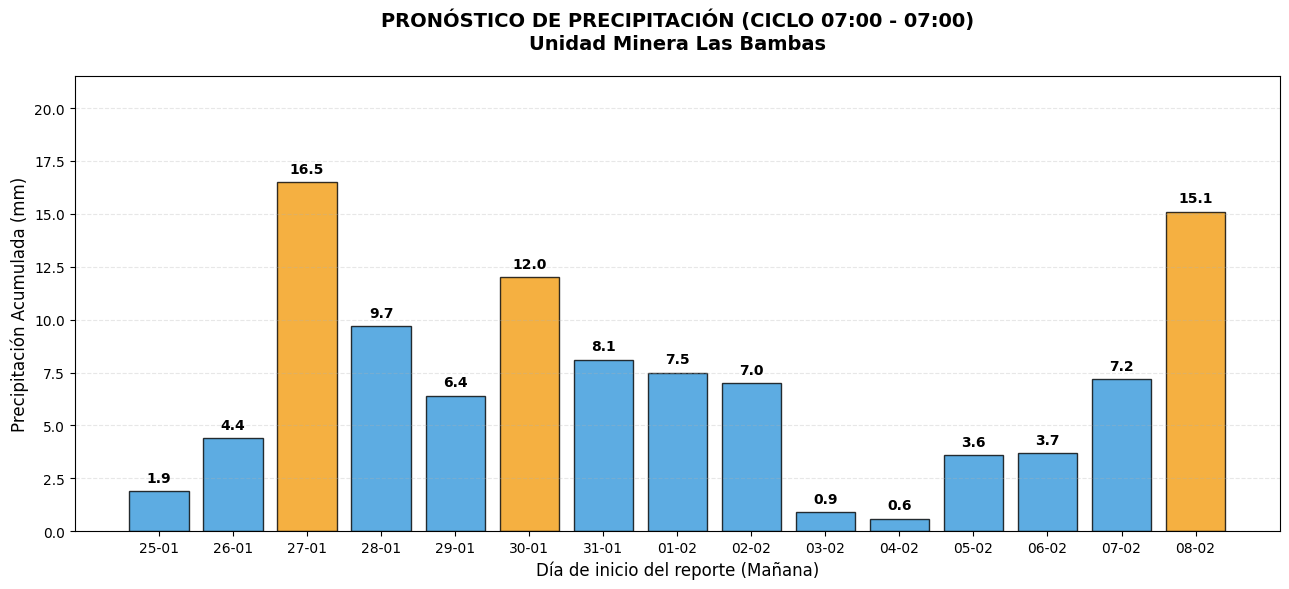


   RESUMEN DE ACUMULADOS CRÍTICOS (LAS BAMBAS)
🌧️ Próximos 5 días:  38.9 mm
🌧️ Próximos 10 días: 74.4 mm
🌧️ Próximos 15 días: 104.6 mm


In [3]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import folium
import matplotlib.pyplot as plt
import numpy as np

# Comando para asegurar visualización en Colab
%matplotlib inline

# 2. CONFIGURACIÓN LAS BAMBAS
LAT_BAMBAS, LON_BAMBAS = -14.0989, -72.3197
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# 3. OBTENCIÓN DE DATOS
params = {
    "latitude": LAT_BAMBAS,
    "longitude": LON_BAMBAS,
    "hourly": "precipitation",
    "timezone": "America/Lima",
    "forecast_days": 16
}
responses = openmeteo.weather_api("https://api.open-meteo.com/v1/forecast", params=params)
response = responses[0]

# 4. PROCESAMIENTO (ESTÁNDAR 07:00 A 07:00)
hourly = response.Hourly()
hourly_precip = hourly.Variables(0).ValuesAsNumpy()
inicio_utc = pd.to_datetime(hourly.Time(), unit="s", utc=True)

df_hourly = pd.DataFrame({
    "fecha_hora": pd.date_range(
        start=inicio_utc,
        periods=len(hourly_precip),
        freq="H"
    ).tz_convert('America/Lima'),
    "precipitacion": hourly_precip
})

# Agrupación diaria estándar SENAMHI
df_senamhi = df_hourly.resample('24H', on='fecha_hora', offset='7H').sum().reset_index().head(15)
df_senamhi['Lluvia_mm'] = df_senamhi['precipitacion'].round(1)

# 5. GRÁFICO DE BARRAS CON UN DECIMAL
print("\n📊 Generando reporte visual...")
fig, ax = plt.subplots(figsize=(13, 6))

fechas_labels = df_senamhi['fecha_hora'].dt.strftime('%d-%m')
valores = df_senamhi['Lluvia_mm']

# Colores por intensidad
colores = ['#3498db' if x < 10 else '#f39c12' if x < 25 else '#e74c3c' for x in valores]

bars = ax.bar(fechas_labels, valores, color=colores, edgecolor='black', alpha=0.8)

# Configuración de ejes
ax.set_title('PRONÓSTICO DE PRECIPITACIÓN (CICLO 07:00 - 07:00)\nUnidad Minera Las Bambas', fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Precipitación Acumulada (mm)', fontsize=12)
ax.set_xlabel('Día de inicio del reporte (Mañana)', fontsize=12)
ax.set_ylim(0, max(valores) + 5) # Espacio para las etiquetas
ax.grid(axis='y', linestyle='--', alpha=0.3)

# ETIQUETAS CON UN DECIMAL: Aquí forzamos el formato ".1f"
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.3, f'{yval:.1f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

# 6. RESUMEN DE ACUMULADOS
print("\n" + "="*65)
print(f"   RESUMEN DE ACUMULADOS CRÍTICOS (LAS BAMBAS)")
print("="*65)
print(f"🌧️ Próximos 5 días:  {df_senamhi.iloc[:5]['Lluvia_mm'].sum():.1f} mm")
print(f"🌧️ Próximos 10 días: {df_senamhi.iloc[:10]['Lluvia_mm'].sum():.1f} mm")
print(f"🌧️ Próximos 15 días: {df_senamhi.iloc[:15]['Lluvia_mm'].sum():.1f} mm")
print("="*65)

# 7. MAPA DE REFERENCIA
m = folium.Map(location=[LAT_BAMBAS, LON_BAMBAS], zoom_start=11)
folium.Marker([LAT_BAMBAS, LON_BAMBAS], popup="Punto de Monitoreo Las Bambas", icon=folium.Icon(color='red', icon='info-sign')).add_to(m)
display(m)

Especificaciones Técnicas del Dataset
1. Origen y Fuente de los Datos
La información se extrae mediante la API de Open-Meteo, una plataforma de datos meteorológicos de código abierto que integra y post-procesa resultados de los modelos numéricos de predicción del tiempo (NWP) más avanzados del mundo:

Modelo Principal: ECMWF (European Centre for Medium-Range Weather Forecasts). Es considerado el estándar en la industria meteorológica por su precisión en latitudes tropicales y zonas complejas.

Modelo de Respaldo: GFS (Global Forecast System - NOAA). Utilizado para la validación de tendencias de largo plazo.

2. Resolución y Cobertura
Resolución Espacial: Los datos operan bajo una malla de 0.1° arcodegrees, lo que equivale aproximadamente a 11 km x 11 km. El pronóstico representa el promedio del área de dicha celda sobre las coordenadas de la unidad minera.

Resolución Temporal: Los datos originales son horarios. El script procesa estas 24 celdas horarias para conformar el acumulado diario bajo el estándar de medición oficial.

3. Estándar Hidrológico (Perú)
A diferencia de los reportes genericos, este dataset ha sido programado para seguir el protocolo del SENAMHI:

Ciclo de 24 horas: De 07:00 AM a 07:00 AM del día siguiente.

Zona Horaria: Ajustada dinámicamente a America/Lima (UTC-5).